In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from preprocessing import EMD_SSA_Denoising
from tqdm import tqdm
import numpy as np
import time
import pandas as pd
from model import Simple1DCNN
from evaluation import calculate_metrics, plot_confusion_matrix, evaluate_model

import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

In [2]:
class PreprocessedDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = torch.from_numpy(self.signals[idx]).float().unsqueeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return signal, label

In [3]:
def visualize_ssa_single_imf(imf_original, denoised_imf, noise_imf, imf_number):
    """
    对单个IMF的SSA分解结果进行可视化，展示主趋势和噪声层。
    （此函数无需修改）
    """
    plt.figure(figsize=(15, 5))
    time_axis = np.arange(len(imf_original))

    plt.plot(time_axis, imf_original, color='gray', linestyle='--', alpha=0.8, label=f'Original IMF {imf_number}')
    plt.plot(time_axis, denoised_imf, color='red', linewidth=1.5, label=f'Principal Trend of IMF {imf_number} (Signal Layer)')
    plt.plot(time_axis, noise_imf, color='green', linewidth=1, alpha=0.7, label=f'Noise Layer of IMF {imf_number}')

    plt.title(f'SSA Decomposition of IMF {imf_number}', fontsize=16)
    plt.xlabel('Sample Points', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'SSA_IMF_{imf_number}_decomposition.png', dpi=300)
    print(f"SSA 分解图已保存为 'SSA_IMF_{imf_number}_decomposition.png'")
    plt.show()


def visualize_emd_ssa_results(preprocessor, original_signal):
    """
    【已改进】
    对单个信号进行EMD-SSA处理并可视化每一步的结果。
    现在会同时对IMF1和IMF2进行单独的SSA分解可视化。
    """
    print("开始执行可视化分析...")

    # --- 1. 执行 EMD 分解 ---
    imfs_and_residue = preprocessor.emd.emd(original_signal, max_imf=5)
    imfs = imfs_and_residue[:-1]
    residue = imfs_and_residue[-1]

    print(f"EMD 分解完成，得到 {len(imfs)} 个 IMF 和 1 个残差。")

    # --- 2. 对IMF1和IMF2进行SSA去噪并可视化 ---
    if len(imfs) >= 1:
        denoised_imf1, noise_imf1 = preprocessor._ssa_denoise_imf(imfs[0], preprocessor.threshold_indices[0])
        print("\n正在对 IMF 1 进行SSA分解并可视化...")
        visualize_ssa_single_imf(imfs[0], denoised_imf1, noise_imf1, imf_number=1)
    else:
        denoised_imf1 = None

    # --- 【修改部分】---
    if len(imfs) >= 2:
        # 现在同时捕获IMF2的趋势和噪声
        denoised_imf2, noise_imf2 = preprocessor._ssa_denoise_imf(imfs[1], preprocessor.threshold_indices[1])
        print("\n正在对 IMF 2 进行SSA分解并可视化...")
        # 为IMF2调用可视化函数
        visualize_ssa_single_imf(imfs[1], denoised_imf2, noise_imf2, imf_number=2)
    else:
        denoised_imf2 = None

    # --- 3. 重构最终的去噪信号 ---
    if denoised_imf1 is not None and denoised_imf2 is not None:
        reconstructed_signal = denoised_imf1 + denoised_imf2
        for i in range(2, len(imfs)):
            reconstructed_signal += imfs[i]
        reconstructed_signal += residue
    else:
        reconstructed_signal = original_signal

    # --- 4. 开始绘制EMD总体分解与对比图 (此部分逻辑不变) ---
    print("\n正在绘制 EMD-SSA 总体流程图...")
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['axes.unicode_minus'] = False

    num_plots = 1 + len(imfs_and_residue) + 1
    fig, axes = plt.subplots(num_plots, 1, figsize=(15, num_plots * 2.5), sharex=True)
    fig.suptitle('EMD-SSA Denoising Process Visualization', fontsize=20)
    time_axis = np.arange(len(original_signal))

    axes[0].plot(time_axis, original_signal, color='black')
    axes[0].set_title('Original Signal', fontsize=16)
    axes[0].grid(True, linestyle='--', alpha=0.6)

    for i, imf in enumerate(imfs_and_residue):
        plot_idx = i + 1
        if i < len(imfs_and_residue) - 1:
            axes[plot_idx].plot(time_axis, imf, color='darkcyan')
            axes[plot_idx].set_title(f'IMF {i + 1}', fontsize=14)
        else:
            axes[plot_idx].plot(time_axis, imf, color='purple')
            axes[plot_idx].set_title('Residue', fontsize=14)
        axes[plot_idx].grid(True, linestyle='--', alpha=0.6)

    final_plot_idx = num_plots - 1
    axes[final_plot_idx].plot(time_axis, original_signal, color='gray', linestyle='--', alpha=0.8, label='Original Signal')
    axes[final_plot_idx].plot(time_axis, reconstructed_signal, color='red', linewidth=1.5, label='Denoised Signal (EMD-SSA)')
    axes[final_plot_idx].set_title('Comparison: Original vs. Denoised Signal', fontsize=16)
    axes[final_plot_idx].set_xlabel('Sample Points', fontsize=14)
    axes[final_plot_idx].legend(loc='upper right', fontsize=12)
    axes[final_plot_idx].grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.savefig(r'EMD_SSA_overall_comparison.png', dpi=300)
    print("EMD-SSA 总体对比图已保存为 'EMD_SSA_overall_comparison.png'")
    plt.show()

In [4]:
ROOT_DIR = r"D:\轴承故障检测竞赛\初赛训练集"
TEST_SIZE, RANDOM_STATE = 0.2, 42
BATCH_SIZE, LEARNING_RATE, NUM_EPOCHS = 64, 0.001, 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

f_paths, labels = [], []
class_names = sorted([d for d in os.listdir(ROOT_DIR) if os.path.isdir(os.path.join(ROOT_DIR, d))])
label_map = {name: i for i, name in enumerate(class_names)}
for class_name, label_int in label_map.items():
    class_dir = os.path.join(ROOT_DIR, class_name)
    for fname in os.listdir(class_dir):
        if fname.endswith(".xlsx"):
            f_paths.append(os.path.join(class_dir, fname))
            labels.append(label_int)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    f_paths, labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels)


In [6]:
params = {'window_len': 16, 'threshold_imf1': 16, 'threshold_imf2': 16}
preprocessor = EMD_SSA_Denoising(**params)

X_train_processed, X_test_processed = [], []
for path in tqdm(train_paths, desc="Processing train signals"):
    signal = pd.read_excel(path, header=None, usecols=[1]).squeeze("columns").to_numpy()
    X_train_processed.append(preprocessor.process(signal))
for path in tqdm(test_paths, desc="Processing test signals"):
    signal = pd.read_excel(path, header=None, usecols=[1]).squeeze("columns").to_numpy()
    X_test_processed.append(preprocessor.process(signal))

Processing test signals: 100%|██████████| 172/172 [00:13<00:00, 13.04it/s]


In [7]:
train_dataset = PreprocessedDataset(np.array(X_train_processed), train_labels)
test_dataset = PreprocessedDataset(np.array(X_test_processed), test_labels)


选择样本进行可视化: D:\轴承故障检测竞赛\初赛训练集\roller_wear_train100\train0316.xlsx
开始执行可视化分析...
EMD 分解完成，得到 5 个 IMF 和 1 个残差。

正在对 IMF 1 进行SSA分解并可视化...
SSA 分解图已保存为 'SSA_IMF_1_decomposition.png'


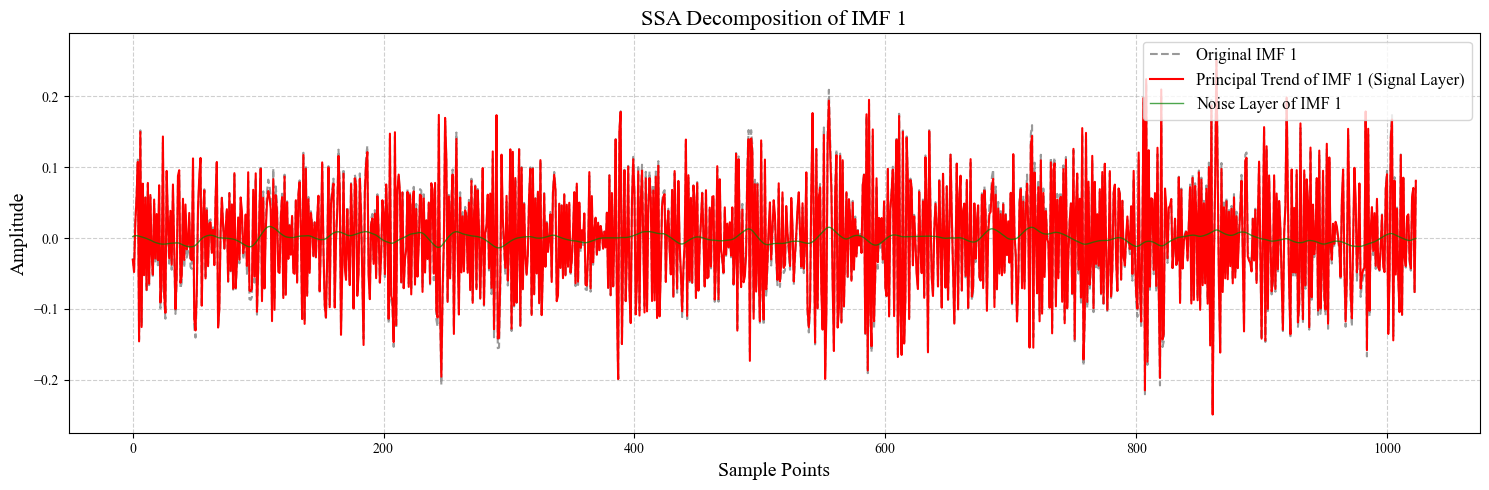


正在对 IMF 2 进行SSA分解并可视化...
SSA 分解图已保存为 'SSA_IMF_2_decomposition.png'


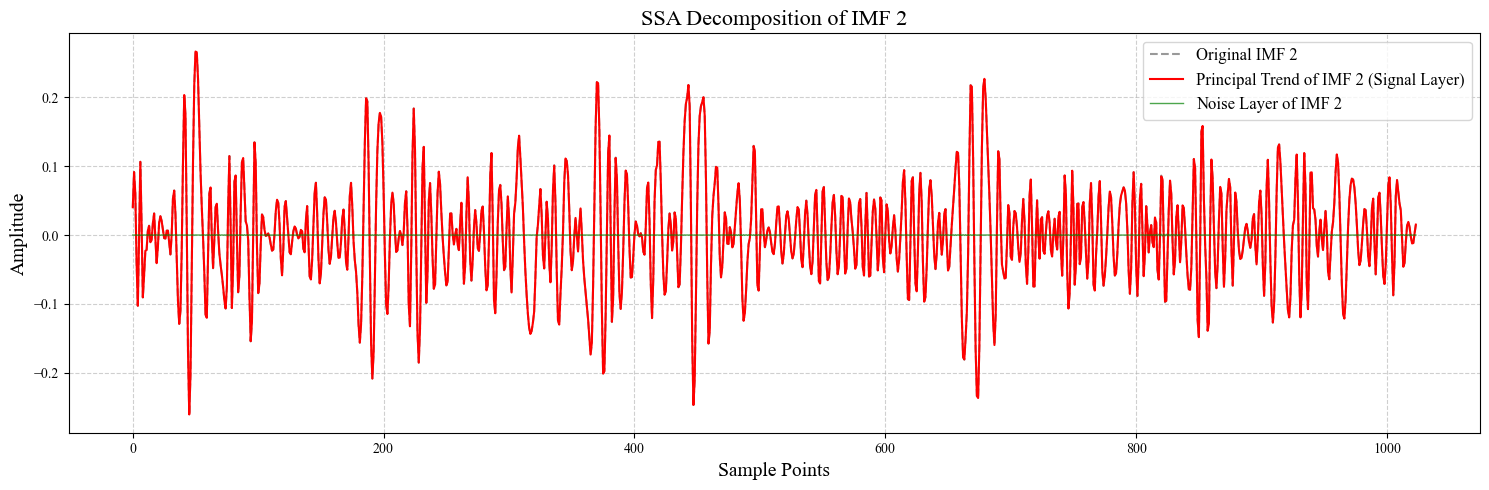


正在绘制 EMD-SSA 总体流程图...
EMD-SSA 总体对比图已保存为 'EMD_SSA_overall_comparison.png'


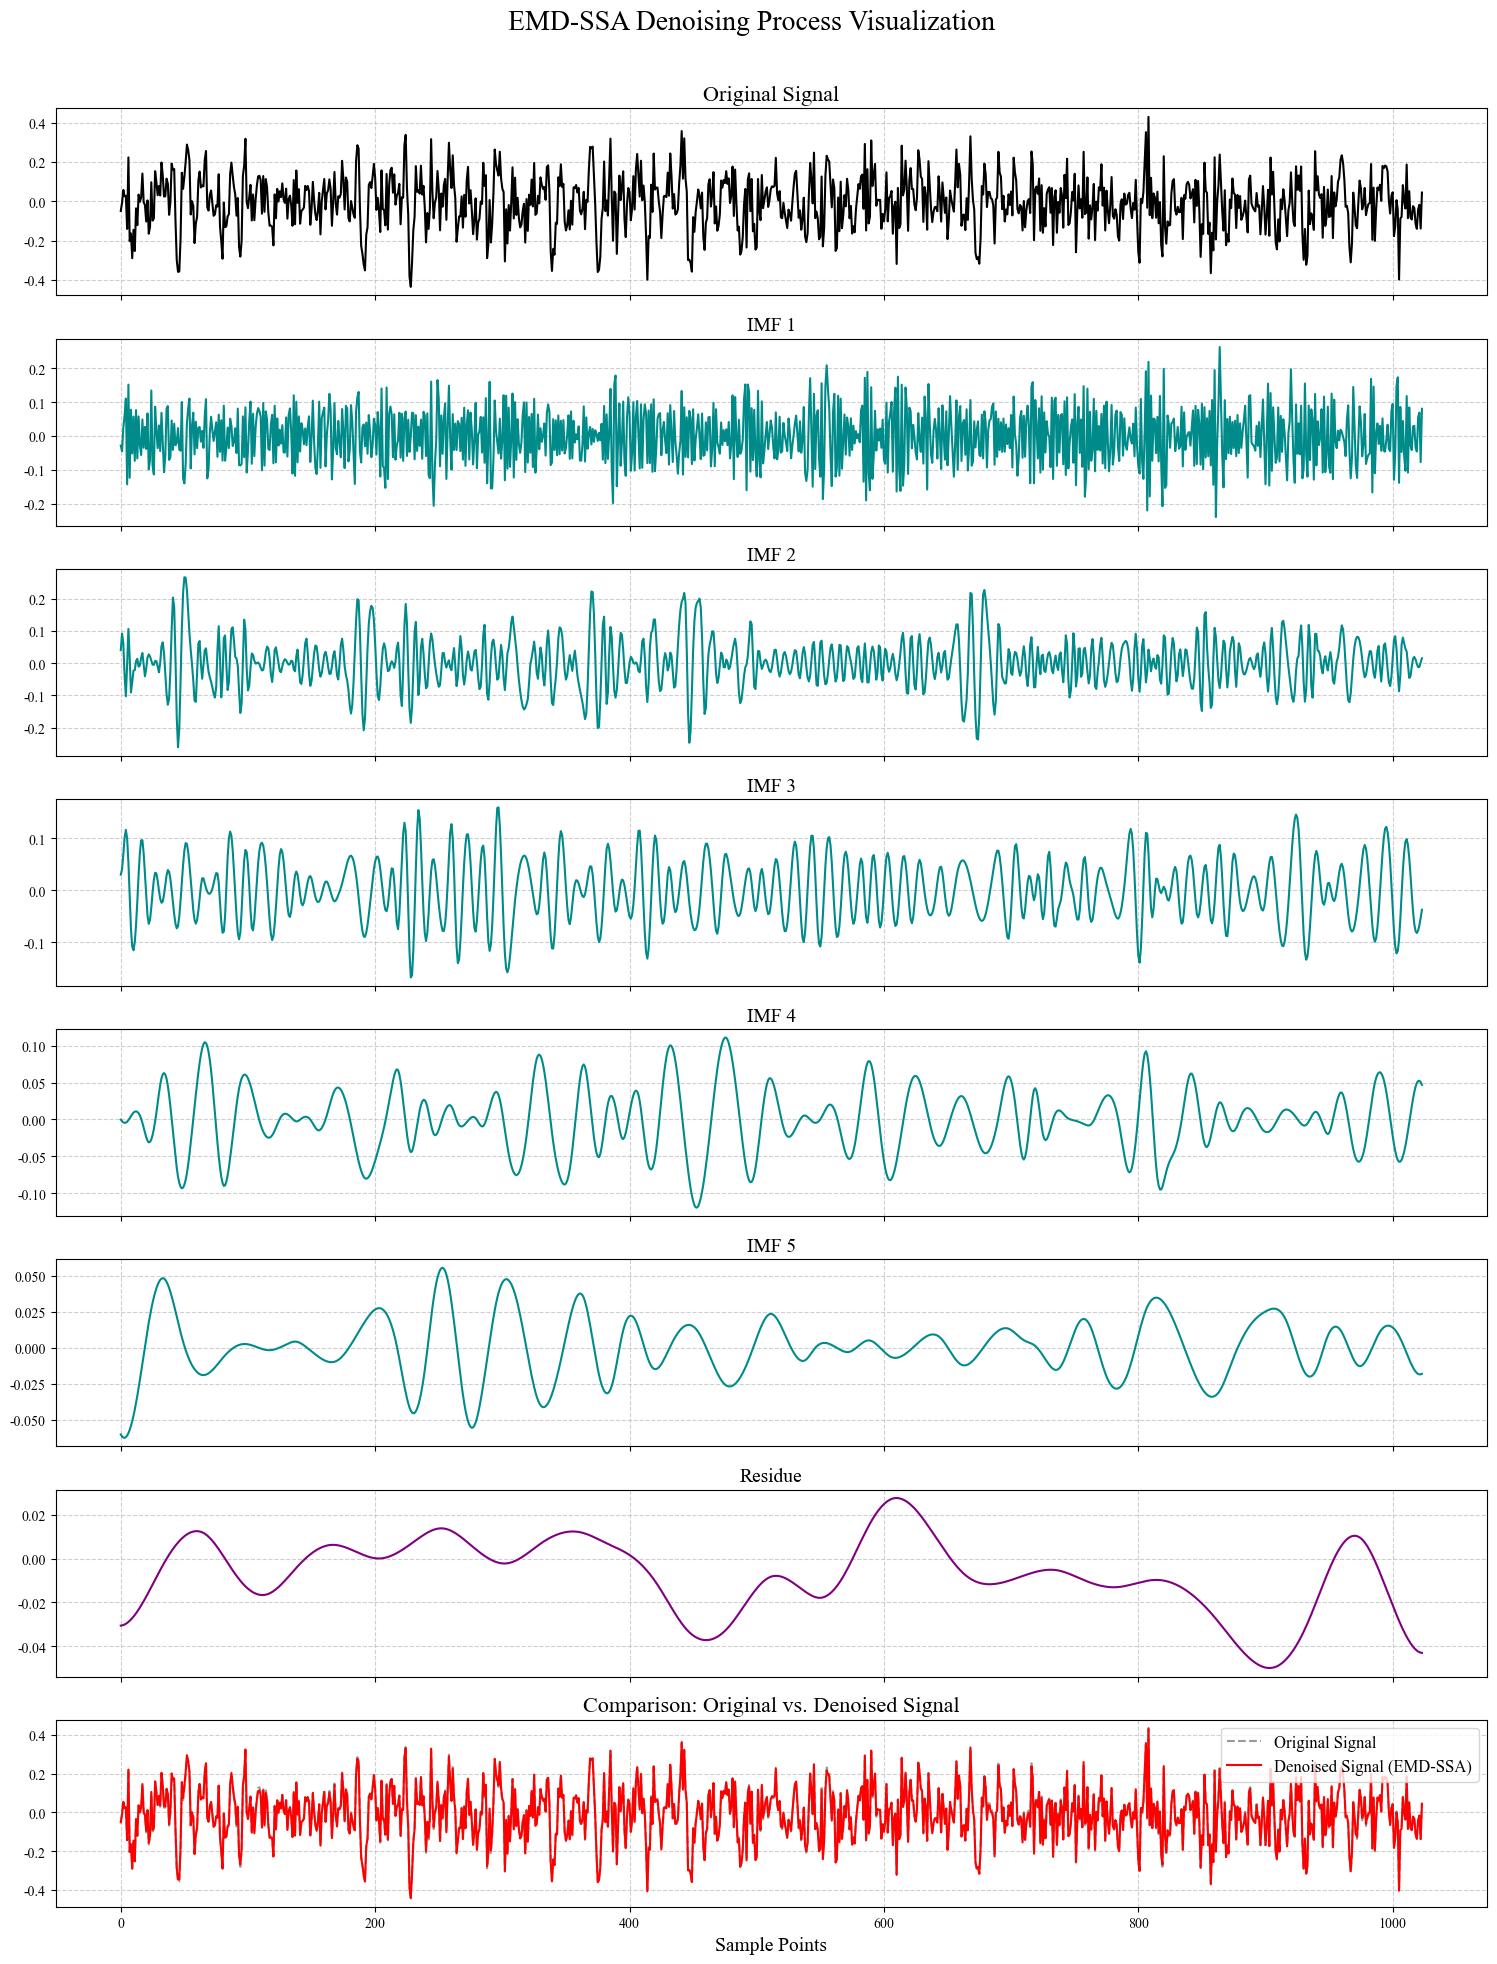

In [8]:
sample_path_to_visualize = train_paths[0]
print(f"\n选择样本进行可视化: {sample_path_to_visualize}")
sample_signal = pd.read_excel(sample_path_to_visualize, header=None, usecols=[1]).squeeze("columns").to_numpy()

preprocessor_for_viz = EMD_SSA_Denoising(**params)
visualize_emd_ssa_results(preprocessor_for_viz, sample_signal)

In [9]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


--- Evaluation Metrics ---
Accuracy: 0.3430
Macro-F1 Score: 0.3805
Macro-Precision: 0.3893
Macro-Recall: 0.3824

Confusion matrix saved as 'confusion_matrix.png'


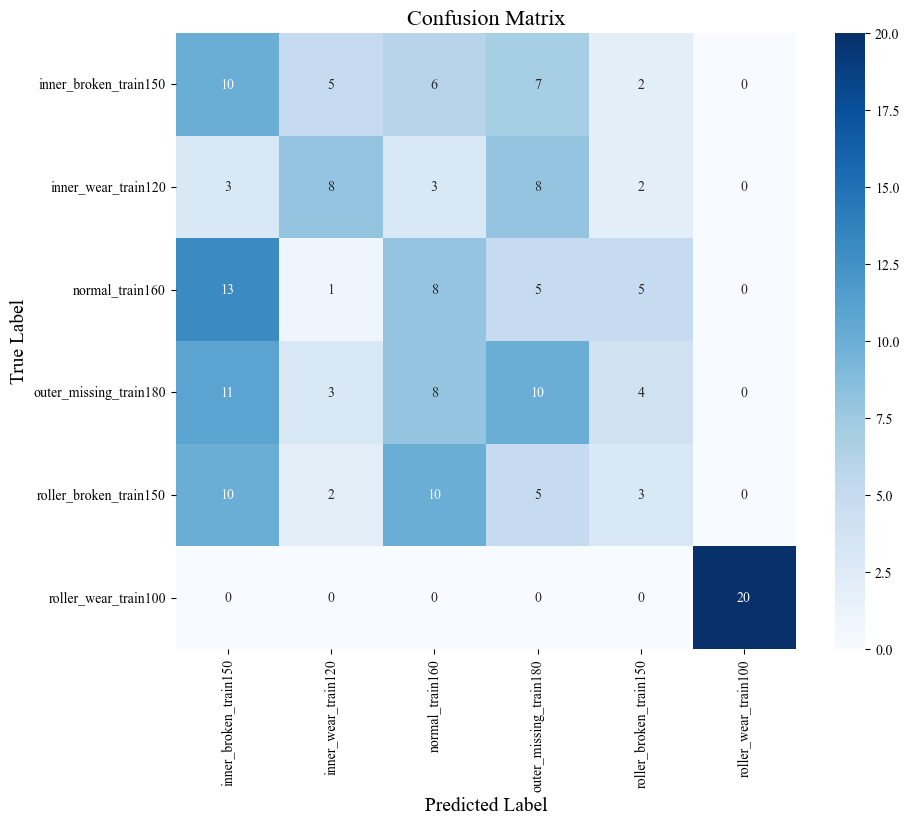

In [10]:
model = Simple1DCNN(num_classes=len(class_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, labs in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS}", leave=False):
        inputs, labs = inputs.to(DEVICE), labs.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    # print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {running_loss / len(train_loader):.4f}")

true_labels, pred_labels = evaluate_model(model, test_loader, DEVICE)
calculate_metrics(true_labels, pred_labels)
plot_confusion_matrix(true_labels, pred_labels, class_names)